In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Perlin Noise
### Solution by: Lyubomir Tankishev
### Course: Math Concepts for Developers

#### Introduction
In this notebook I will show my solution for generating 2D Perlin Noise and show some of its implementations.

#### Contents
1. [What is Perlin Noise?](#what_is)
2. [How does it work?](#how_does_it_work)
3. [Solution](#my_solution)
    1. [Generating the distance matrix for the distance vectors](#gen_distance_vectors)
    2. [Generating the gradient vectors](#gen_gradient_vectors)
    3. [Generating the corner gradient vector matrices](#gen_subgrid_gradient_vector_matrices)
    4. [Calculation of the dot products and gradient values](#calculate_gradient)
4. [Putting it all together](#perlin_noise)
5. [Playing around with the code](#lets_play)
6. [Trying out 2D animation](#lets_animate)
7. Next steps

<a id='what_is'></a>
#### 1. What is Perlin Noise

The movie Looker from 1981 is the first movie to use a fully computer generated model of the human body as well as the first to use 3D shaded computer generated image (CGI). The 1980s were the years that CGI became an integral part of the movie business. This period some of the best classical computer games were also written. 

One of the challenges of CGI at the time was the machine look and feel of the textures. The Perlin Noise algorithm was developed to solve this. In simple terms, Perlin Noise is an algorithm for generation of pseudo random noise with a more organic look & feel to it. This algorithm was created by Ken Perlin in the early 1980s to solve the need for procedural generation of textures for the increasing use of computer generated images in the movie industry. Later it was heavily adopted by the computer games as well. 

##### Random noise vs. pseudo random noise with organic look to it
To understand better the concept lets first create a 2D fully random image.

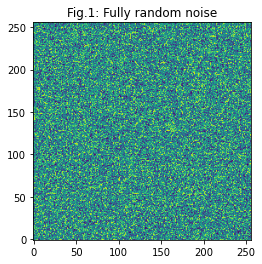

In [3]:
def fully_random_generation(size):
    """
    This function generates an random noise image of given size 
    """
    
    arr = np.random.rand(size ** 2)
    arr = arr.reshape([size, size])
    plt.imshow(arr)
    plt.gca().invert_yaxis()
    plt.title("Fig.1: Fully random noise")
    plt.show()
    
fully_random_generation(256)

Now, lets compare the image above with the next one which is generated using the 2D Perlin Noise algorithm that is described in this book. One can easily notice that although there is randomness in the Perlin Noise image it is much more natural looking. If applied to a texture it will look more organic.

<p style="text-align: left;"><b>Fig.2:</b> Perlin Noise</p>
<img src="perlin_noise_256px8x8.png" width="256" height="256" align="left"/>

<a id='how_does_it_work'></a>
#### 2. How does it work?
The 2D Perlin Noise algorithm works by computing the a value for each pixel (cell) in an image (grid of pixels) as a function of the pixels location and a set of gradient vectors. The image is broken down to sub grids and a gradient vector is assigned to the corner of each sub grid. Each sub grid contains a number of pixels. The larger then number of subgrids, the higher the granularity in the final image. Setting a sub grid of equal to the image grid size (each grid contaning single pixel) will ultimately generate a result similar to random noise. 

<img src="https://upload.wikimedia.org/wikipedia/commons/0/09/PerlinNoiseGradientGrid.png" width="512" height="256" align="center"/><p style="text-align: center;"><b>Fig.3:</b>Grid and random gradient vectors <a href="https://en.wikipedia.org/wiki/Perlin_noise">(source)</a></p>

The random assignment of the vectors creates randomnes in the image. Their area of effect (pixes impacted by the vectors) blends the randomness as the value for each pixel is correlated to that of the surrounding ones. To calculate the said value (the gradient value of each pixel) a the dot product is calculated of the applicable gradient vectors and the distance vectors of that pixel to the corners of the sub grid.

<img src="https://codelirium.com/public/images/perlin-noise/perlin-algo-1.png" width="512" height="256" align="center"/><p style="text-align: center;"><b>Fig.4:</b>Gradient and distance vectors <a href="https://codelirium.com/article/perlin-noise">(source)</a></p>

Finaly the resulting dot products are interpolated to get the resulting gradient value of the selected pixel. This process is repeated for each pixel in the image to generate the final result.

<img src="https://codelirium.com/public/images/perlin-noise/perlin-algo-2.png
" width="512" height="256" align="center"/><p style="text-align: center;"><b>Fig.5:</b>Interpolation of dot products <a href="https://codelirium.com/article/perlin-noise">(source)</a></p>

<a id='my_solution'></a>
#### 3. My solution
Most of the solutions found online focus on defining a gradient calculation function that is then applied to each pixel. I have approached this solution applying linear algebra methods to calculate the whole gradient matrix in one go. On my computer this approach yields significantly faster results. 

My personal preference is to code in sections defining several functions each implementing a step from the final code.

<a id='gen_distance_vectors'></a>
<u>A. Generating the distance matrix for the distance vectors</u><br>
The fist step is to generate a matrix for the distance vectors. This matrix contains the relative distance of each pixel from the gradient vectors that surround it. We generate the matrix only once as it is applicable for all pixels. The output of the function is a 3D matrix and contains two  2D matrices (one for the $x$ and $y$ coordinates of the distance vectors).

In [4]:
def gen_distance_vectors(size: int, elements: int):
    """
    This functoin generates a distance matrix for each pixel.
    Inputs:
        size: int - pixels per row in the image
        elements: int - pixels per row in each subgrid
    """
    D = np.zeros((2, size, size))
    if elements == 1:
        return D
    
    A = np.tile(np.arange(size), size).reshape((size, size))

    D[0] = (D[0,:,:] + A % elements) / (elements - 1)
    D[1] = D[0].T
    
    D = np.flip(D, 1)
    return D

# Example
s = 6
DV = gen_distance_vectors(s, 3)
Z = np.array(list(zip(DV[1].reshape(s**2, 1), DV[0].reshape(s**2, 1)))).reshape(s, s, 2)
for i in range(s):
    print(Z[i].tolist())

[[1.0, 0.0], [1.0, 0.5], [1.0, 1.0], [1.0, 0.0], [1.0, 0.5], [1.0, 1.0]]
[[0.5, 0.0], [0.5, 0.5], [0.5, 1.0], [0.5, 0.0], [0.5, 0.5], [0.5, 1.0]]
[[0.0, 0.0], [0.0, 0.5], [0.0, 1.0], [0.0, 0.0], [0.0, 0.5], [0.0, 1.0]]
[[1.0, 0.0], [1.0, 0.5], [1.0, 1.0], [1.0, 0.0], [1.0, 0.5], [1.0, 1.0]]
[[0.5, 0.0], [0.5, 0.5], [0.5, 1.0], [0.5, 0.0], [0.5, 0.5], [0.5, 1.0]]
[[0.0, 0.0], [0.0, 0.5], [0.0, 1.0], [0.0, 0.0], [0.0, 0.5], [0.0, 1.0]]


<a id='gen_gradient_vectors'></a>
<u>B. Generating the gradient vectors</u><br>
Next we will generate our gradient vectors. For purpose we will first create a tuple of possible vectors. After that we will randomly select the number of vectors that we need in accordance with the size of our gradient sub grid. <br>

The usual implementation of Perlin Noise uses the following set of four or eight vectors:<br>
$\big\{(1, 1), (-1, 1), (1, -1), (-1, -1)\big\}$; or<br>
$\big\{(1, 1), (-1, 1), (1, -1), (-1, -1), (\sqrt{2}, 0), (0, \sqrt{2}), (-\sqrt{2}, 0), (0, -\sqrt{2})\big\}$<br>

That said i wanted to have the flexibility to define my own vectors that are equally spaced in a circle with a radius of $1$ and having values between $-1$ and $1$. Using numpy.linspace we can easily achieve that.
```python
v = np.linspace(0, 2 * np.pi, number_of_unique_vectors + 1)
vx = np.round(np.cos(v), 5)
vy = np.round(np.sin(v), 5)
vectors = tuple(zip(vx, vy))
```
The `+ 1` in the first line is added because $\sin 0$ and $\sin 2\pi$ are the same (similary for $\cos x$). All that is left then is to randomly select a number of vectors for our grid.

In [5]:
def plot_vectors(vectors):
    """
    Helper function for ploting vectors
    """
    V = np.array(vectors)
    ax = plt.gca()
    ax.set_aspect("equal")
    ax.quiver(np.zeros(len(V)), np.zeros(len(V)), V[:,0], V[:,1], angles='xy', scale_units='xy', scale=1)
    ax.set_ylim(-1.5, 1.5) 
    ax.set_xlim(- 1.5, 1.5)
    plt.title('Unique vectors to select from')
    plt.show()
    
def generate_gradient_vectors(number_of_unique_vectors: int, number_of_vectors: int, showcase=False) -> np.ndarray:
    """
    This function generates a list of gradient vectors to be used for the generation of the perlin noise.
    The function first creates a list with unique vectors equaly spaced on a radiant coordinate system.
    It then randomly selects the required number of vectors and returs the result.
    
    Inputs:
        number_of_unique_vectors: int - number of unique vectors to create
        number_of_vectors: int - number of vectors to return as output
        showcase: bool - used to visualize the unique vectors if needed
    """
    
    v = np.linspace(0, 2 * np.pi, number_of_unique_vectors + 1)
    vy = np.round(np.sin(v), 5)
    vx = np.round(np.cos(v), 5)
    vectors = tuple(zip(vx, vy))
    vectors = vectors[:-1]
    if showcase:
        plot_vectors(vectors)
    
    vector_indexes = list(range(number_of_unique_vectors))
    random_indexes = np.random.choice(vector_indexes, size=number_of_vectors)
    
    retval = np.zeros((2, number_of_vectors))
    retval[0] = np.array([vectors[idx][0] for idx in random_indexes])
    retval[1] = np.array([vectors[idx][1] for idx in random_indexes])
    
    return retval

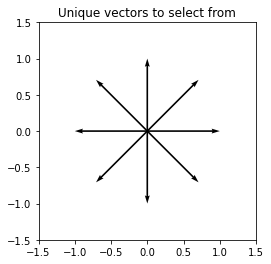

Selected vectors:
[(0.0, 1.0), (-0.0, -1.0), (0.70711, -0.70711), (0.70711, -0.70711), (-0.70711, -0.70711), (0.70711, -0.70711), (0.70711, 0.70711), (0.70711, -0.70711), (0.0, 1.0)]


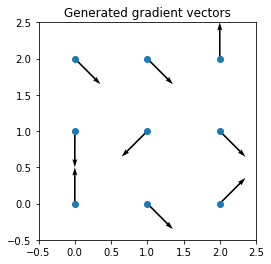

In [6]:
# Example: generating 9 vectors for a 3x3 matrix representing a image split with a 2x2 subgrid division
Z = generate_gradient_vectors(8, 9, True)
print(f'Selected vectors:\n{list(zip(Z[0,:], Z[1,:]))}')

X = np.arange(3).repeat(3)
Y = np.tile(np.arange(3),3)
    
ax = plt.gca()
ax.set_aspect("equal")
ax.quiver(X, Y, Z[0,:], Z[1,:], angles='xy', scale_units='xy', scale=2)
ax.scatter(X,Y)
ax.set_ylim(-0.5, 2.5) 
ax.set_xlim(-0.5, 2.5)
plt.title('Generated gradient vectors')
plt.show()

<a id='gen_subgrid_gradient_vector_matrices'></a>
<u>C. Generating the corner gradient vector matrices</u><br>
Since we are targeting to calculate the gradients for all pixels at the same time it is helpful to create a set of matrices containing the top-left (TL), top-right (TR), bottom-left (BL) and bottom-right (BR) gradient vectors for all pixels in the image.
<br>

In [7]:
def corner_matrix(matrix, grid_size, v_num, corner):
    if corner not in ('tr','tl','br','bl'):
        return
    retval = np.zeros((2, grid_size, grid_size))
    el_num = grid_size // (v_num - 1)
    
    for i in range(2):
        m = matrix[i,:]

        m = np.reshape(m, (v_num, v_num))
        m = np.flip(m, 0)

        if corner == 'tl':
            m = m[:-1,:-1]
        elif corner == 'tr':
            m = m[:-1,1:]
        elif corner == 'bl':
            m = m[1:,:-1]
        elif corner == 'br':
            m = m[1:,1:]
    
        m = np.reshape(m.repeat(el_num), ((v_num - 1),grid_size)).repeat(el_num, axis=0)

        retval[i] = m
    return retval

<a id='calculate_gradient'></a>
<u>D. Calculation of the dot products and gradient values</u><br>
Next we compute the gradient values for each pixel. This is done in four steps:
* Generate the distance vector matrix (see above);
* Generate the set of four courner gradient vector matrices (see above);
* Calculate the dot product of the gradient and distance vectors; and
* Interpolate the results

Calculating the dot product
```python
    DPBL = D[0] * BL[0] + D[1] * BL[1]
    DPBR = (D[0] - 1) * BR[0] + D[1] * BR[1]
    DPTL = D[0] * TL[0] + (D[1] - 1) * TL[1]
    DPTR = (D[0] - 1) * TR[0] + (D[1] - 1) * TR[1]

    L1 = DPBL + (DPBR - DPBL) * X
    L2 = DPTL + (DPTR - DPTL) * X
    G = L1 + (L2 - L1) * Y
```
Where:
* D - distance vector matrix
* TL, TR, BL, BR - the four corner matrices
* Y - a matrix for the smoothening function (see below)
* G - the resulting gradient matrix

Finaly, we need to interpolate the results to get the gradient value of the pixel. To do that we will use the following equations (where $t_{x}$ is the relative position of the pixel on the x-axis and $t_{y}$ is the relative position of the pixel on the y-axis; we can get both from the `dm` matrix): 

$$l_{0}=d_{00}+t_{x}*(d_{01}-d_{00})$$
$$l_{1}=d_{10}+t_{x}*(d_{11}-d_{10})$$
$$gradient=l_{0}+t_{y}*(l_{1}-l_{0})$$

We can use linear interpolation, but the Perlin Noise algorithm uses a S-curve one for better results. For this algorithm we will use the same fade function, namely:
$$6t^5-15t^4+10t^3$$

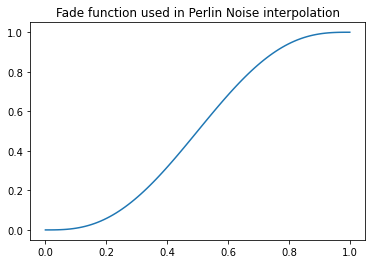

In [8]:
def fade_noise(x):
    """
    Function used to generate a fade noise matrix for dot product interpolation 
    """
    retval = np.zeros((x.shape))
    retval += x**5 * 6 - x**4 * 15 + x**3 * 10 
    return retval

# Example of the fade_noise function
X = np.linspace(0,1,100)
Y = fade_noise(X)
plt.plot(X, Y)
plt.title('Fade function used in Perlin Noise interpolation')
plt.show()

<a id='perlin_noise'></a>
#### 4. Putting it all together
Finally, we can put everything together and we should get a nice 2D image with pseudo random noise.

In [9]:
def generate_perlin(grid_size=256, subgrids=2, unique_vectors_to_select_from=8, vectors_matrix=None, **kwargs):
    """
    Algorithm to generate Perlin Noise gradient vector.
    
    Inputs:
        grid_size: int - number of pixels per row
        subgrids: int - number of splits of the image grid (per row)
        unique_vectors_to_select_from: int - number of unique gradient vectors to generate
        [optional] vectors_matrix: ndarray - gradient vectors matrix to use. If not provided, the algorithm will generate one
    """
    
    # Set-up
    v_num = subgrids + 1
    el_num = grid_size // subgrids
    grid_vectors_number = v_num ** 2
     
    # Generate distance matrix
    D = gen_distance_vectors(grid_size, el_num)
      
    # Generate gradient vectors 
    if vectors_matrix is None:
        V = generate_gradient_vectors(unique_vectors_to_select_from, v_num**2)
    else:
        V = vectors_matrix
        
    # Generate gradient corners 
    TL = corner_matrix(V, grid_size, v_num, 'tl')
    TR = corner_matrix(V, grid_size, v_num, 'tr')
    BL = corner_matrix(V, grid_size, v_num, 'bl')
    BR = corner_matrix(V, grid_size, v_num, 'br')
    
    # Generate interpolation matrix
    X = fade_noise(D[0])
    Y = fade_noise(D[1])
 
    # Calculate dot products
    DPBL = D[0] * BL[0] + D[1] * BL[1]
    DPBR = (D[0] - 1) * BR[0] + D[1] * BR[1]
    DPTL = D[0] * TL[0] + (D[1] - 1) * TL[1]
    DPTR = (D[0] - 1) * TR[0] + (D[1] - 1) * TR[1]

    L1 = DPBL + (DPBR - DPBL) * X
    L2 = DPTL + (DPTR - DPTL) * X
    G = L1 + (L2 - L1) * Y

    return G


def plot_perlin(**kwargs):
    """
    A function to plot Perlin Noise
    """
    G = generate_perlin(**kwargs)
    if 'title' in kwargs:
        plt.title(kwargs.get('title'))
    plt.imshow(G)
    plt.gca().invert_yaxis()
    plt.show()

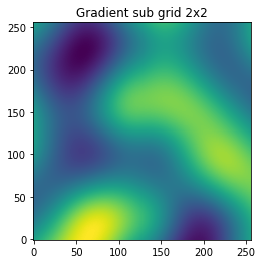

In [10]:
plot_perlin(title='Gradient sub grid 2x2', subgrids=2)

<a id='lets_play'></a>
#### 4. Playing around with the algorithm
The first thing to play around with is the granularity (trying the algorithm with different gradient grid sizes). We can notice how increasing the number of sub grids (and gradient thus number of gradient vectors) and effectively reducing the number of pixels in each gradient grid creates a more textured look.

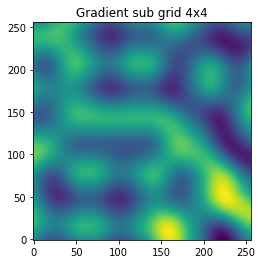

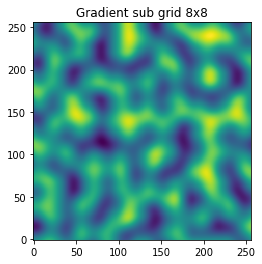

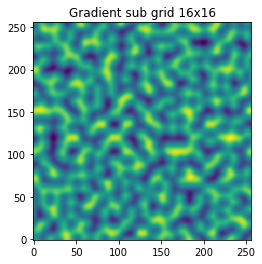

In [11]:
plot_perlin(title='Gradient sub grid 4x4', subgrids=4)
plot_perlin(title='Gradient sub grid 8x8', subgrids=8)
plot_perlin(title='Gradient sub grid 16x16', subgrids=16)

Another cool thing is to overlay several layers of Perlin noise on top of each other. By doing so we can add fine details to our main texture. First we create a base layer. We then create a number of layers each consecutive one with higher granularity but also with lower amplitude of the output values. We can then sum all layers (flatten them) to get a more detailed texture. 

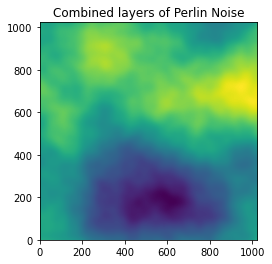

In [12]:
G1 = generate_perlin(grid_size=1024, subgrids=1)
G2 = generate_perlin(grid_size=1024, subgrids=2)/4
G3 = generate_perlin(grid_size=1024, subgrids=4)/8
G4 = generate_perlin(grid_size=1024, subgrids=8)/16
G5 = generate_perlin(grid_size=1024, subgrids=16)/32
G = G1 + G2 + G3 + G4 + G5
plt.imshow(G)
plt.gca().invert_yaxis()
plt.title("Combined layers of Perlin Noise")
plt.show()

Finally, let's plot the same data but in a 3D image. This will generate a nice fine detail terain map. I think it is pretty cool!

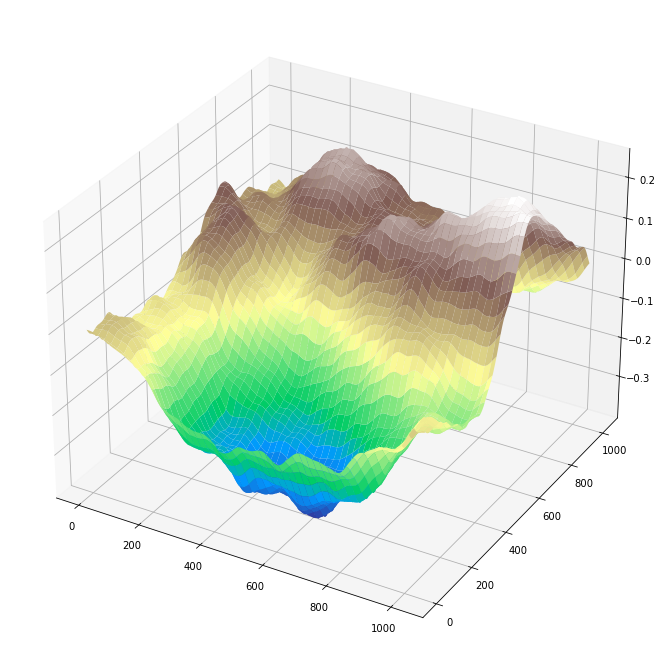

In [13]:
# Plotting on a 3d field with terrain colors
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(1024), range(1024))
ax.plot_surface(X, Y, G, cmap='terrain')
plt.show()

<a id='lets_animate'></a>
#### 5. Playing around with animation
We can also play with the Perlin Noise generator to create some beautiful 2D animation.
To do this first we will need to create a transformation function that will rotate our gradient vectors.
For simplicity i have decided to rotate all vectors in the same direction. That said, the function could be rewritten so that each vector is rotated at a different direction and at a different angle.

In [14]:
def rotate_vectors(M, degrees=30):
    """
    This function rotates the vectors received in the vector matrix (M) by a given angle in degrees
    """
    size = M.shape[0]
    theta = np.deg2rad(degrees)
    T_M = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    M = np.dot(T_M, M)

    return M

To create the animation we will create a gradient vectors matrix and then rotate it in each frame.

<IPython.core.display.Javascript object>


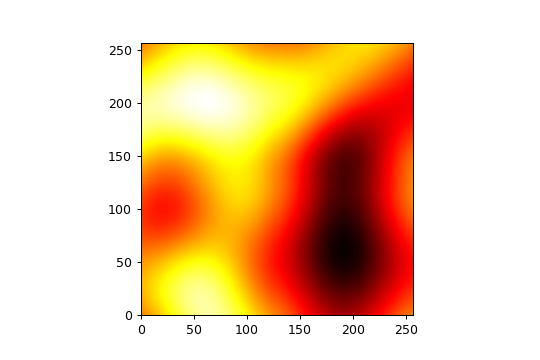

In [15]:
%matplotlib notebook

# Perlin noise set-up
size = 256
subgrids = 2
unique_vectors_to_select_from = 8
v_num = subgrids + 1
v = generate_gradient_vectors(unique_vectors_to_select_from, v_num**2)
G = generate_perlin(grid_size=size, subgrids=subgrids, vectors_matrix=v)

# Animation set-up
rotation_angle = 5
frames = 600
frame_interval = 30
fig = plt.figure()
ax = plt.axes(xlim=(0, size), ylim=(0, size))
im = plt.imshow(G, cmap='hot')

def init():
    global v, G, im
    v  = rotate_vectors(v, rotation_angle)
    G = generate_perlin(grid_size=size, subgrids=subgrids, vectors_matrix=v)   
    im.set_data(G)
    return [im]

# Animation function
def animate(i):
    global v, im, G
    v  = rotate_vectors(v, rotation_angle)
    G = generate_perlin(grid_size=size, subgrids=subgrids, vectors_matrix=v)
    im.set_array(G)
    return [im]

anim = FuncAnimation(fig, animate, init_func=init, frames=frames, interval=frame_interval, blit=True)
plt.show()

#### 7. Next steps
There are several areas for improvement of the current algorithm, including:
* Refactoring the code to generate also 3D;